In [3]:
import pyspark as ps
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time

In [4]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df case study") \
            .getOrCreate()
sc = spark.sparkContext

In [5]:
results_df = spark.read.csv('data/2019-Ironman-World-Championship-Results.csv',
                            header=True,
                            quote='"',
                            sep=',',
                            inferSchema=True)

In [404]:
'''
schema = StructType( [
    StructField('Bib',     IntegerType(), True),
    StructField('Name',   StringType(),  True),
    StructField('Country',  StringType(), True),
    StructField('Gender',  StringType(),  True),
    StructField('Swim', StringType(), True),
    StructField('Bike', StringType(),   True),
    StructField('Run', StringType(),   True),
    StructField('Overall', StringType(),   True),
    StructField('Division Rank', IntegerType(),   True),
    StructField('Gender Rank', IntegerType(),   True),
    StructField('Overall Rank', IntegerType(),   True),
    StructField('T1', StringType(),   True),
    StructField('T2', StringType(),   True),
] )
'''

"\nschema = StructType( [\n    StructField('Bib',     IntegerType(), True),\n    StructField('Name',   StringType(),  True),\n    StructField('Country',  StringType(), True),\n    StructField('Gender',  StringType(),  True),\n    StructField('Swim', StringType(), True),\n    StructField('Bike', StringType(),   True),\n    StructField('Run', StringType(),   True),\n    StructField('Overall', StringType(),   True),\n    StructField('Division Rank', IntegerType(),   True),\n    StructField('Gender Rank', IntegerType(),   True),\n    StructField('Overall Rank', IntegerType(),   True),\n    StructField('T1', StringType(),   True),\n    StructField('T2', StringType(),   True),\n] )\n"

In [6]:
results_df.printSchema()
results_df.columns

root
 |-- BIB: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- Swim: string (nullable = true)
 |-- Bike: string (nullable = true)
 |-- Run: string (nullable = true)
 |-- Overall: string (nullable = true)
 |-- Division Rank: string (nullable = true)
 |-- Gender Rank: string (nullable = true)
 |-- Overall Rank: string (nullable = true)
 |-- T1: string (nullable = true)
 |-- T2: string (nullable = true)



['BIB',
 'Name',
 'Country',
 'Gender',
 'Division',
 'Swim',
 'Bike',
 'Run',
 'Overall',
 'Division Rank',
 'Gender Rank',
 'Overall Rank',
 'T1',
 'T2']

In [11]:
df = results_df.toPandas()
df

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,4,"Frodeno, Jan",DEU,Male,MPRO,00:47:31,04:16:02,02:42:43,07:51:13,1,1,1,00:01:58,00:02:59
1,6,"O'donnell, Tim",USA,Male,MPRO,00:47:38,04:18:11,02:49:45,07:59:41,2,2,2,00:02:01,00:02:06
2,5,"Kienle, Sebastian",DEU,Male,MPRO,00:52:17,04:15:04,02:49:56,08:02:04,3,3,3,00:02:12,00:02:35
3,14,"Hoffman, Ben",USA,Male,MPRO,00:51:01,04:24:01,02:43:08,08:02:52,4,4,4,00:02:25,00:02:17
4,11,"Wurf, Cameron",AUS,Male,MPRO,00:52:25,04:14:44,02:55:03,08:06:41,5,5,5,00:02:07,00:02:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,544,"Sudut, Martin",USA,Male,M65-69,None,None,None,None,DNS,DNS,DNS,None,None
2430,471,"Bourdillon, Patrick",USA,Male,M70-74,None,None,None,None,DNS,DNS,DNS,None,None
2431,476,"Evenson, Even",USA,Male,M70-74,None,None,None,None,DNS,DNS,DNS,None,None
2432,454,"Cooper, D. Mark",USA,Male,M75-79,None,None,None,None,DNS,DNS,DNS,None,None


In [15]:
# Convert None in Swim, Bike, Run, Overall, T1, and T2 to datetime
# These need to be converted to time intervals NOT datetime (<- time stamp)
# pd.to_timedelta
cols_to_clean = ['Swim', 'Bike', 'Run', 'Overall', 'T1', 'T2']
df[cols_to_clean] = df[cols_to_clean].apply(pd.to_timedelta, unit='s')
df.dtypes

BIB                        int32
Name                      object
Country                   object
Gender                    object
Division                  object
Swim             timedelta64[ns]
Bike             timedelta64[ns]
Run              timedelta64[ns]
Overall          timedelta64[ns]
Division Rank             object
Gender Rank               object
Overall Rank              object
T1               timedelta64[ns]
T2               timedelta64[ns]
dtype: object

In [19]:
# Convert DNS & DNF to 0
df.loc[df['Division Rank'] == 'DNS', 'Division Rank'] = 0
df.loc[df['Division Rank'] == 'DNF', 'Division Rank'] = 0
df.loc[df['Division Rank'] == 'DQ', 'Division Rank'] = 0
df['Division Rank'] = df['Division Rank'].astype(int)

df

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,4,"Frodeno, Jan",DEU,Male,MPRO,00:47:31,04:16:02,02:42:43,07:51:13,1,1,1,00:01:58,00:02:59
1,6,"O'donnell, Tim",USA,Male,MPRO,00:47:38,04:18:11,02:49:45,07:59:41,2,2,2,00:02:01,00:02:06
2,5,"Kienle, Sebastian",DEU,Male,MPRO,00:52:17,04:15:04,02:49:56,08:02:04,3,3,3,00:02:12,00:02:35
3,14,"Hoffman, Ben",USA,Male,MPRO,00:51:01,04:24:01,02:43:08,08:02:52,4,4,4,00:02:25,00:02:17
4,11,"Wurf, Cameron",AUS,Male,MPRO,00:52:25,04:14:44,02:55:03,08:06:41,5,5,5,00:02:07,00:02:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,544,"Sudut, Martin",USA,Male,M65-69,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT
2430,471,"Bourdillon, Patrick",USA,Male,M70-74,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT
2431,476,"Evenson, Even",USA,Male,M70-74,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT
2432,454,"Cooper, D. Mark",USA,Male,M75-79,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT


In [30]:
male_results = df[df['Gender'] == 'Male']
male_pro = male_results[male_results['Division'] == 'MPRO']
male_agegroup = male_results[male_results['Division'] != 'MPRO']

In [31]:
fem_results = df[df['Gender'] == 'Female']
fem_pro = fem_results[fem_results['Division'] == 'FPRO']
fem_agegroup = fem_results[fem_results['Division'] != 'FPRO']

In [55]:
df2 = fem_results[fem_results['Division Rank'] > 80]
df2

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
2084,328,"Weldon, Stephanie",USA,Female,F45-49,01:36:21,07:27:53,05:32:24,14:54:04,81,541,2091,00:07:14,00:10:12
2107,325,"Seidensticker, Nicki",USA,Female,F45-49,01:35:02,07:21:22,05:57:11,15:10:17,82,551,2114,00:10:18,00:06:24
2125,1370,"Mailland, Magaly Kay",FRA,Female,F45-49,01:28:19,07:28:41,06:09:43,15:19:07,83,562,2132,00:05:24,00:07:00
2156,327,"Vu, Heidi",VNM,Female,F45-49,01:22:41,07:48:27,06:17:47,15:40:02,84,574,2163,00:05:14,00:05:53
2177,322,"Bolton, Justine",AUS,Female,F45-49,01:15:15,07:26:14,06:44:20,15:52:14,85,582,2184,00:10:44,00:15:41


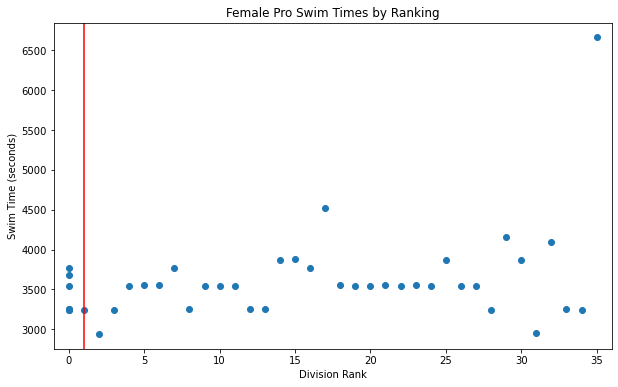

In [64]:
x = fem_pro['Division Rank']
y = fem_pro['Swim'].apply(lambda x: x.total_seconds())

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y)
ax.set_title('Female Pro Swim Times by Ranking')
ax.set_xlabel('Division Rank')
ax.set_ylabel('Swim Time (seconds)')
ax.set_xlim(-1, 36)
ax.axvline(1, c='r')